# KD 指標選股與回測

條件：KD<20 & K>D 黃金交叉時買進；KD>80 & K<D 死亡交叉時賣出

回測步驟：
* 讀取歷史資料
* 計算回測指標
* 回測演算法設計
* 紀錄回測資料
* 績效計算

In [1]:
import sqlite3, os
import talib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 讀取歷史資料 - 0050 近五年資料

In [2]:
conn = sqlite3.connect(os.path.join('data', 'data.db'))

sqlstr = "select sid,date,開盤價,最高價,最低價,收盤價,成交股數 \
          from price where sid='0050' and date>datetime('2015-01-01')"
df = pd.read_sql(sqlstr, conn, index_col='date', parse_dates='date')

In [3]:
print(len(df))
df.drop_duplicates(inplace=True)  # 刪除重覆資料
print(len(df))
df.head()

1280
1277


,sid,開盤價,最高價,最低價,收盤價,成交股數
date,,,,,,
2015-01-05,0050,66.40,66.75,66.00,66.55,6295612
2015-01-06,0050,65.75,65.75,64.75,64.90,19501826
2015-01-07,0050,64.70,65.25,64.70,65.00,6991542
2015-01-08,0050,65.50,66.60,65.50,66.50,13153525
2015-01-09,0050,66.90,66.95,66.05,66.15,5891981


In [19]:
# pivot: 將 DataFrame 進行列與欄的轉置

high = df.pivot(index='date', columns='sid')['最高價']
low = df.pivot(index='date', columns='sid')['最低價']
close = df.pivot(index='date', columns='sid')['收盤價']

In [22]:
print(len(high))
#high['0050'].head()
high['0050'].ffill().values

1278


array([66.75, 65.75, 65.25, ..., 78.7 , 76.15, 77.2 ])

In [23]:
# 計算 KD 指標
# ffill: fill the missing value in the dataframe
# ‘forward fill’ and will propagate last valid observation forward

kd = talib.STOCH(high['0050'].ffill().values, 
                 low['0050'].ffill().values, 
                 close['0050'].ffill().values,
                 fastk_period=9, slowk_period=3
                 , slowd_period=3, slowk_matype=1, slowd_matype=1)
kd

(array([        nan,         nan,         nan, ..., 71.97598007,
        73.54257519, 75.63591642]),
 array([        nan,         nan,         nan, ..., 60.5998684 ,
        67.0712218 , 71.35356911]))

In [24]:
# 將 kd 值 分別轉換成 k、d 兩條 series
k = pd.Series(kd[0], index=close['0050'].index)
d = pd.Series(kd[1], index=close['0050'].index)
print (k, d)

date
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
2015-01-09          NaN
                ...    
2020-03-25    48.919744
2020-03-26    62.292572
2020-03-27    71.975980
2020-03-30    73.542575
2020-03-31    75.635916
Length: 1278, dtype: float64 date
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
2015-01-09          NaN
                ...    
2020-03-25    36.154942
2020-03-26    49.223757
2020-03-27    60.599868
2020-03-30    67.071222
2020-03-31    71.353569
Length: 1278, dtype: float64


In [27]:
print(k[15], k[14], k[16])

94.30789543381462 92.9015051533433 95.8718964348561


In [32]:
k.shift(1)

date
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
2015-01-09          NaN
                ...    
2020-03-25    29.994965
2020-03-26    48.919744
2020-03-27    62.292572
2020-03-30    71.975980
2020-03-31    73.542575
Length: 1278, dtype: float64

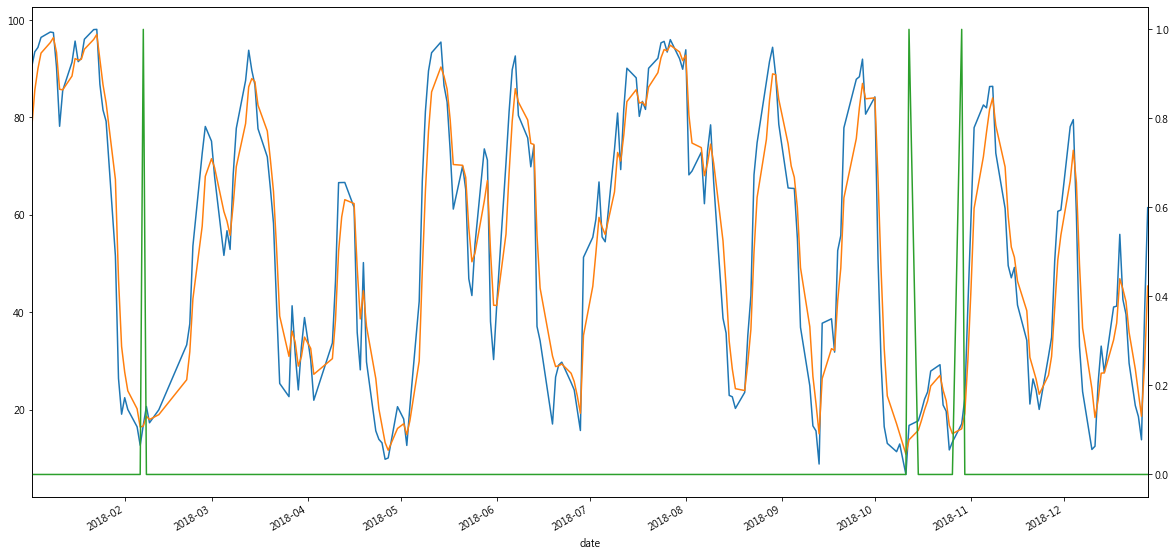

In [37]:
# & 代表 「且」 的意思，這邊的條件就是
# k.shift(1) 可以想成「昨天」的意思，同理 k.shift(2) 就是前天
# 當（今天的 k > d ）且 （昨天的 k < d） 且 （今天的 k < 30） 時，買入

buy = (k > d) & (k.shift(1) < d.shift(1)) & (k < 20)

plt.rcParams['figure.figsize'] = (20, 10)
k['2018'].plot()     #k.plot() 畫全部資料圖，指定年分可縮小範圍
d['2018'].plot()
buy['2018'].astype(int).plot(secondary_y=True)

In [38]:
buy[buy == True]

date
2015-06-10    True
2015-08-24    True
2016-01-13    True
2016-05-10    True
2016-12-27    True
2017-03-07    True
2018-02-07    True
2018-10-12    True
2018-10-29    True
2019-05-21    True
2019-05-24    True
2019-05-29    True
dtype: bool

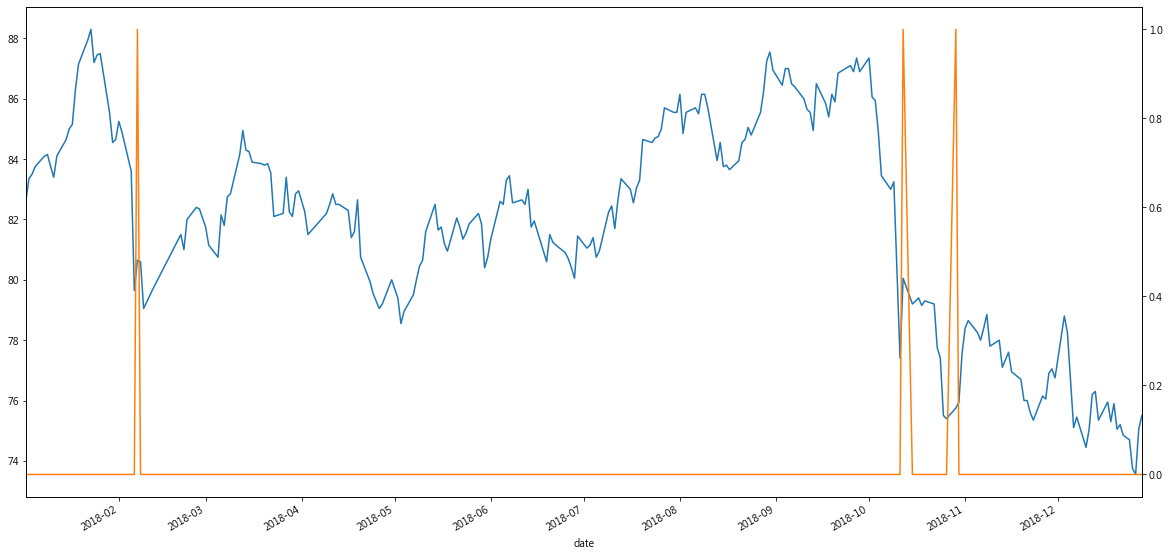

In [39]:
# 畫 2 條線，看 0050 收盤價跟 k, d 值算出來的買點 buy 有無關連
close['0050']['2018'].plot()
buy['2018'].astype(int).plot(secondary_y=True)

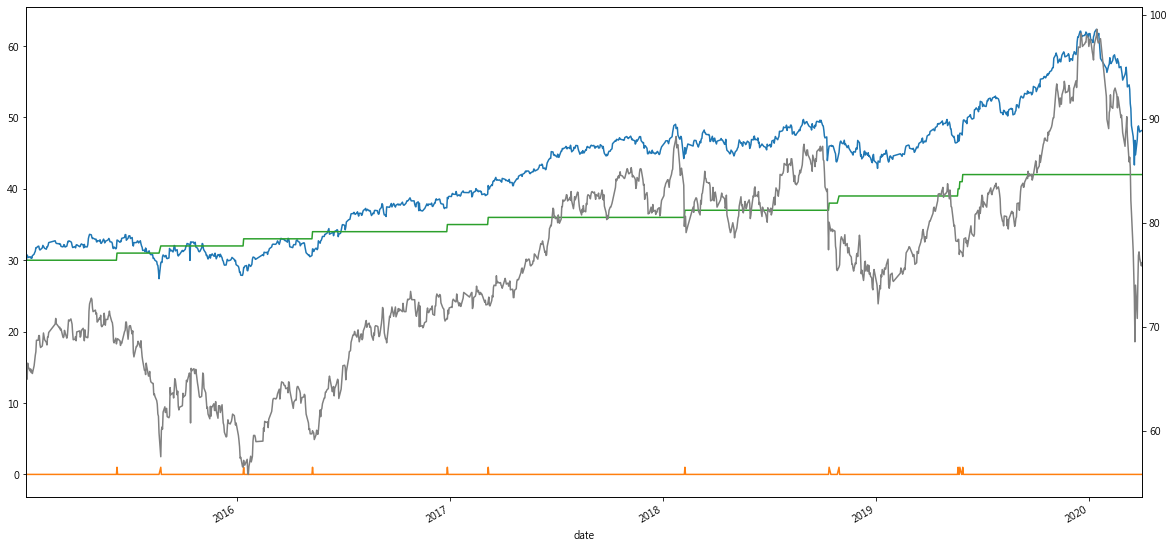

In [45]:
# 起始資金為 30 萬
arr = [30]

for v, p in zip(buy[1:], close['0050'].shift(-2)/close['0050'].shift(-1)):
    arr.append(arr[-1]*p + v)

# 繪製 0050 收盤價圖
close['0050'].plot(secondary_y=True, color='gray')

# 繪製投資獲利
pd.Series(arr, index=close['0050'].index).plot()

# 繪製買入的時間點
buy.astype(int).plot()

# 繪製一樣的金額放在銀行的資產變化
(buy.astype(int).cumsum() + 30).plot()